<a href="https://colab.research.google.com/github/ValerioGiannetti/progetti/blob/main/TropicTaste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import log_loss,accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import math
import numpy as np

In [ ]:
def visualizza_distribuzione_target(target):
  sns.histplot(x=target)

In [ ]:
def get_features_target(data):
  X = data.drop(['Frutto','Frutto_Encoded'],axis=1).values
  y = data['Frutto_Encoded'].values
  return X,y

In [ ]:
def analisi_dataset(data):
  print("-----HEAD-------")
  print(data.head(20))
  print("-----COLUMSN------")
  print(data.columns)
  print("-----INFO------")
  print(data.info())
  print("----DESCRIBE-------")
  print(data.describe(include="all").T)
  print("-----VALORI NULL------")
  print(data.isna().sum())


RANDOM_SEED = 0
df = pd.read_csv("https://proai-datasets.s3.eu-west-3.amazonaws.com/fruits.csv")

analisi_dataset(df)

-----HEAD-------
   Frutto  Peso (g)  Diametro medio (mm)  Lunghezza media (mm)  \
0    Mela     86.40                89.68                  8.69   
1    Mela     77.58                73.45                  6.49   
2    Mela     81.95                81.66                  6.40   
3    Mela     66.33                36.71                  6.78   
4    Mela     56.73                75.69                  5.78   
5    Mela     86.05                61.68                  3.62   
6    Mela     99.24                69.19                  5.64   
7    Mela    111.21                67.36                  5.47   
8    Mela     76.60                61.57                  6.46   
9    Mela     86.85                76.00                  6.36   
10   Mela     74.25                62.80                  3.93   
11   Mela     87.40                61.39                  6.06   
12   Mela     60.24                81.04                  5.18   
13   Mela     80.90                57.52                  7

Sull'esplorazione del dataset vediamo che non ci sono valori null

Un dato come mean e std sull'osservazione peso dove abbiamo una media di 47g e un std di 26.7 questo significa che c'è una dispersione nel dataset.

Poi una considerazione sul diametro la mean e std sono molto vicine questo ci fa suppore che potrebber esserci degli outlier come sulla Durezza(1-10)

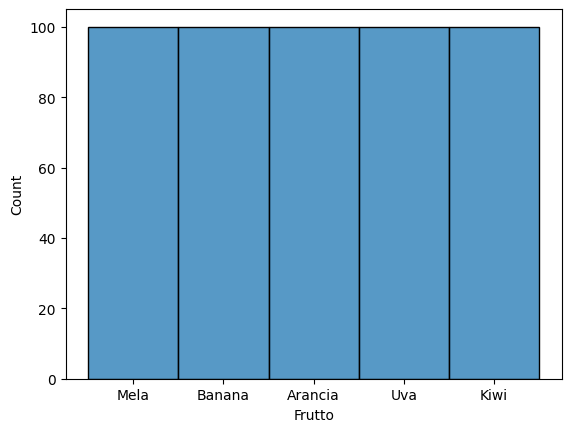

In [ ]:
visualizza_distribuzione_target(df['Frutto'])

Su questo istogramma possiamo vedere che la distribuzione della variabile target è equa

In [ ]:
def visualizzazione_pairplot(data):
  sns.pairplot(data=data[['Peso (g)','Diametro medio (mm)','Lunghezza media (mm)','Durezza buccia (1-10)','Dolcezza (1-10)','Frutto']],hue='Frutto')

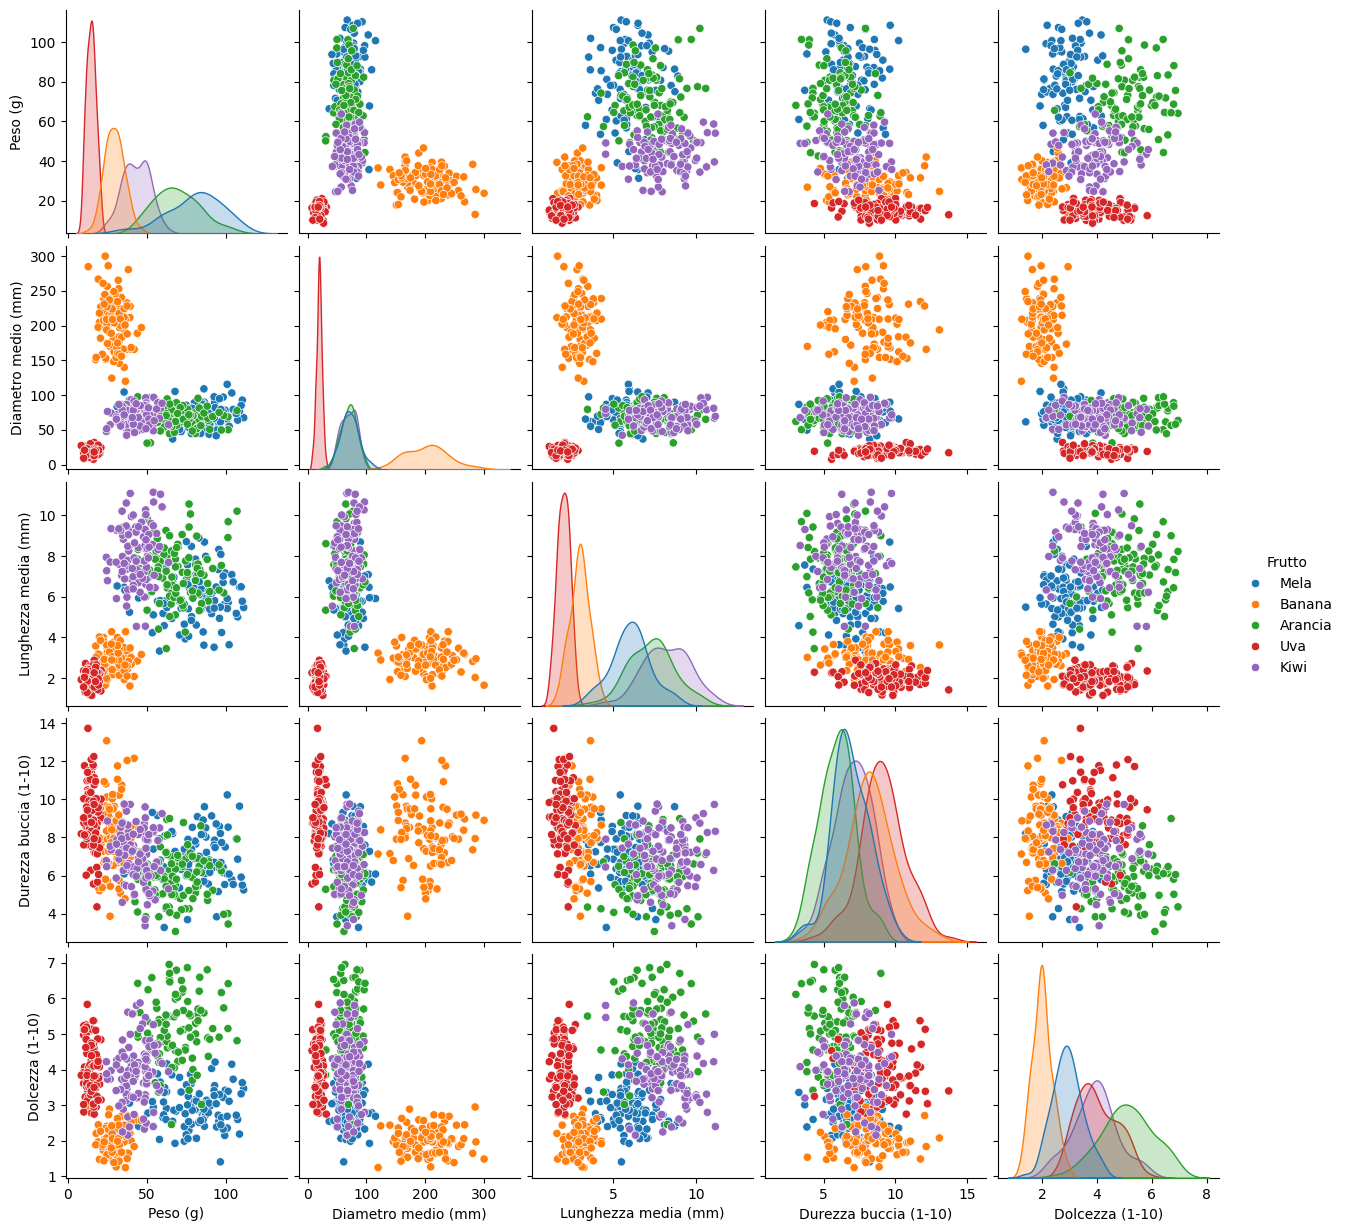

In [ ]:
visualizzazione_pairplot(df)

In [ ]:
le = LabelEncoder()
df['Frutto_Encoded'] = le.fit_transform(df['Frutto'])

In [ ]:
X,y = get_features_target(df)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=RANDOM_SEED)

In [ ]:
Ks = [1,2,3,4,5,10,12,15,20,25,30,40,50,60]
# Dizionario per accumulare i risultati (es. accuracy) per ogni K
results = {K: [] for K in Ks}

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

for train_index, val_index in kf.split(X_train):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]

    rbs = RobustScaler()
    X_tr = rbs.fit_transform(X_tr)
    X_val = rbs.transform(X_val)

    for K in Ks:
        knn = KNeighborsClassifier(n_neighbors=K,weights='distance')
        knn.fit(X_tr, y_tr)

        # IMPORTANTE: Valutiamo sul set di VALIDAZIONE, non solo sul training
        score = knn.score(X_val, y_val)
        results[K].append(score)

# Calcoliamo la media per ogni K
mean_results = {K: np.mean(scores) for K, scores in results.items()}

# Troviamo il K migliore
best_k = max(mean_results, key=mean_results.get)

print(f"Il miglior valore di K è: {best_k} con un'accuracy media di {mean_results[best_k]:.4f}")

Il miglior valore di K è: 20 con un'accuracy media di 0.9375


Provo il modello con il K migliore dato dal cross-validation

In [ ]:
rbs = RobustScaler()
X_train = rbs.fit_transform(X_train)
X_test = rbs.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=best_k,weights='distance')
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        21
           1       1.00      1.00      1.00        19
           2       0.80      0.89      0.84        18
           3       0.94      0.88      0.91        17
           4       1.00      1.00      1.00        25

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



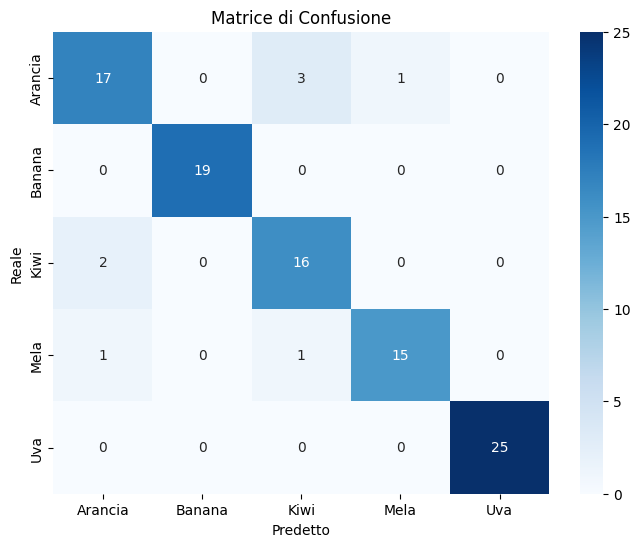

In [19]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=le.classes_,yticklabels=le.classes_)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Matrice di Confusione')
plt.show()

Questo Heatmap mostra come il frutto uva e banana vengono classificati correttamente dal modello KNN mentre fatica su arance e mele , come abbiamo visto dal pairplot, dove i punti dei due frutti sono sovrapposti tra loro.

